In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact

from lifetime_modeling import *

In [2]:
load_execution_time_from_csv("timing.csv")
load_embodied_values_from_csv("embodied-carbon.csv")
load_memory_from_csv("memory.csv")


In [ ]:
# -----------------------------------------
# 2) Set up interactive widgets
# -----------------------------------------
workload_dropdown = widgets.Dropdown(
    options=execution_time.keys(),
    value="Food Spoilage Detection",
    description="Workload:",
)

lifetime_slider = widgets.FloatSlider(
    value=1.0,
    min=MIN_LIFETIME,
    max=MAX_LIFETIME,
    step=0.5,
    description='Lifetime (yrs)'
)

inf_freq_slider = widgets.BoundedFloatText(
    value=1.0,
    min=MIN_INF_FREQ,
    max=MAX_INF_FREQ,
    step=1.0,
    description='Number of Executed Tasks per Year'
)

power_source_dropdown = widgets.Dropdown(
    options=carbon_intensity_values.keys(),
    value=list(carbon_intensity_values.keys())[0],
    description="Power Source:",
)

carbon_intensity_box = widgets.Text(
    value=carbon_intensity_values[power_source_dropdown.value],
    description="Carbon Int. (CO₂/unit energy)",
)

carbon_intensity_box.disabled = True
def update_carbon_intensity(*args):
    if power_source_dropdown.value == "Custom":
        carbon_intensity_box.disabled = False
    else:
        carbon_intensity_box.value = carbon_intensity_values[power_source_dropdown.value]
        carbon_intensity_box.disabled = True

power_source_dropdown.observe(update_carbon_intensity, 'value')

core_freq_box = widgets.BoundedFloatText(
    value=10000.0,
    min=1000.0,
    max=100000.0,
    step=100.0,
    description='Core Freq'
)

ui = widgets.VBox([
    workload_dropdown,
    lifetime_slider,
    inf_freq_slider,
    power_source_dropdown,
    carbon_intensity_box,
    core_freq_box
])

out = widgets.interactive_output(
    plot_carbon_vs_lifetime,
    {
        'workload_choice': workload_dropdown,
        'lifetime_yrs': lifetime_slider,
        'inf_freq': inf_freq_slider,
        'carbon_intensity': carbon_intensity_box,
        'core_freq': core_freq_box,
    }
)

display(ui, out)

Output()

In [4]:
import matplotlib.pyplot as plt

def plot_serv_embodied_vs_energy_per_inference():
    workloads = list(sram.keys())
    x_embodied = []
    y_energy_per_inf = []
    labels = []

    for workload in workloads:
        # Get Serv max embodied carbon
        try:
            embodied = embodied_values[workload]["Serv"]["Carbon Footprint Max (gCO2e)"]
        except KeyError:
            continue  # skip if not available

        # Get energy per inference for Serv
        # Use default core_freq = 10000 (arbitrary, since energy per inference is independent of frequency)
        system = "Serv"
        core_freq = 10000  # Hz, but cancels out
        sram_bytes = sram[workload] + rf_sram
        lprom_bytes = lprom[workload]
        system_power = system_specs[system]["power"]
        total_power = system_power + (sram_power + sram_overhead_power) * sram_bytes * 8 + lprom_power * lprom_bytes * 8
        time_per_inference = execution_time[workload][system] / core_freq
        energy_per_inference = total_power * time_per_inference  # in Joules

        x_embodied.append(embodied)
        y_energy_per_inf.append(energy_per_inference)
        labels.append(workload)

    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(x_embodied, y_energy_per_inf)

    for i, label in enumerate(labels):
        ax.annotate(label, (x_embodied[i], y_energy_per_inf[i]), fontsize=9, xytext=(5,2), textcoords='offset points')

    ax.set_xlabel("Serv Max Embodied Carbon (gCO2e)")
    ax.set_ylabel("Energy per Inference (Joules)")
    ax.set_yscale('log')
    ax.set_title("Serv Max Embodied Carbon vs Energy per Inference for Each Workload")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_serv_embodied_vs_energy_per_inference()


KeyError: 'Tree Tracking'

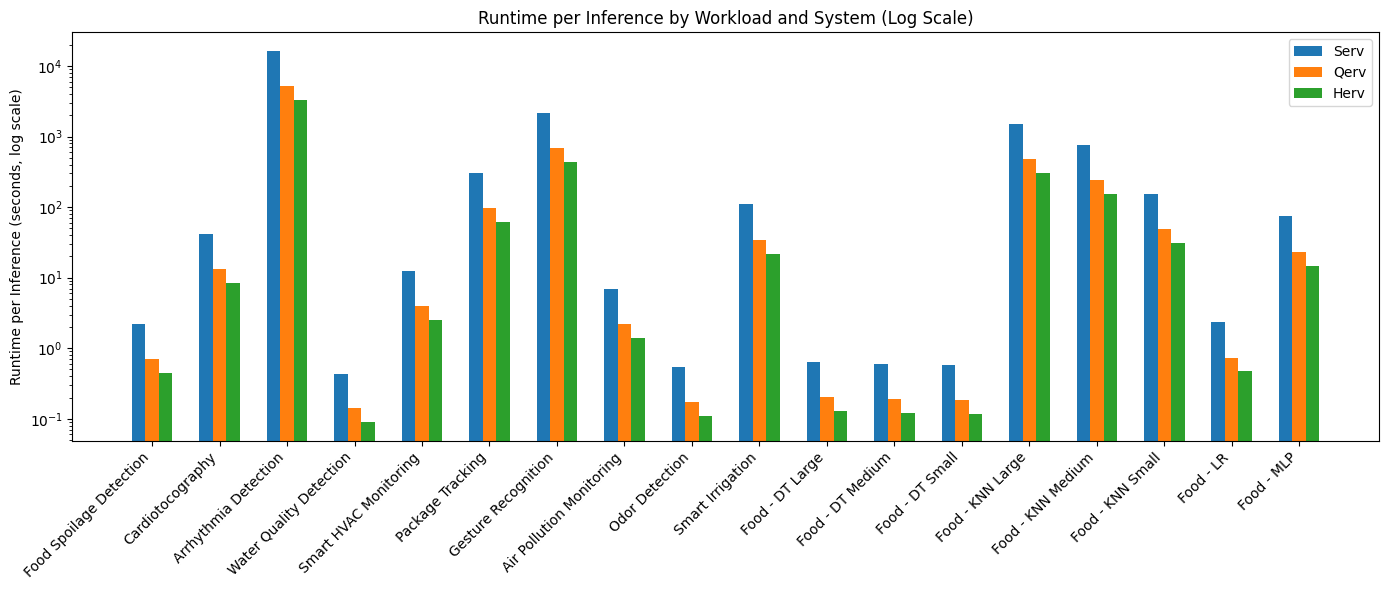

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_runtime_per_workload_log():
    workloads = list(execution_time.keys())
    systems = ["Serv", "Qerv", "Herv"]
    core_freq = 10000  # arbitrary, cancels out for relative comparison

    runtimes = {system: [] for system in systems}
    labels = []

    for workload in workloads:
        try:
            for system in systems:
                runtime = execution_time[workload][system] / core_freq
                runtimes[system].append(runtime)
            labels.append(workload)
        except KeyError:
            # skip if not available
            for system in systems:
                runtimes[system].append(np.nan)
            labels.append(workload)

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 6))
    rects = []
    for i, system in enumerate(systems):
        rect = ax.bar(x + (i - 1) * width, runtimes[system], width, label=system)
        rects.append(rect)

    ax.set_yscale('log')
    ax.set_ylabel('Runtime per Inference (seconds, log scale)')
    ax.set_title('Runtime per Inference by Workload and System (Log Scale)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_runtime_per_workload_log()
